<a href="https://colab.research.google.com/github/sajeebju/Deep-Learning/blob/main/Salt_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
im_width = 128
im_height = 128
border = 5
path_train = "/content/drive/MyDrive/Python/TGS/train/images/"
path_train_masks = "/content/drive/MyDrive/Python/TGS/train/masks/"

In [4]:
ids = next(os.walk(path_train))[2]
masks = next(os.walk(path_train_masks))[2]
print("No. of images = ", len(ids))
print("No. of masks = ", len(masks))

No. of images =  4000
No. of masks =  4000


In [5]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [6]:
for n, i in tqdm_notebook(enumerate(ids), total=len(ids)):

    images = load_img(path_train+i, grayscale=True)
    img = img_to_array(images)
    img = resize(img, (128, 128, 1), mode = 'constant', preserve_range = True)

    mask = img_to_array(load_img(path_train_masks+i, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)

    X[n] = img/255.0
    y[n] = mask/255.0

<ipython-input-6-7de69585548b>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, i in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/4000 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

Text(0.5, 1.0, 'Salt')

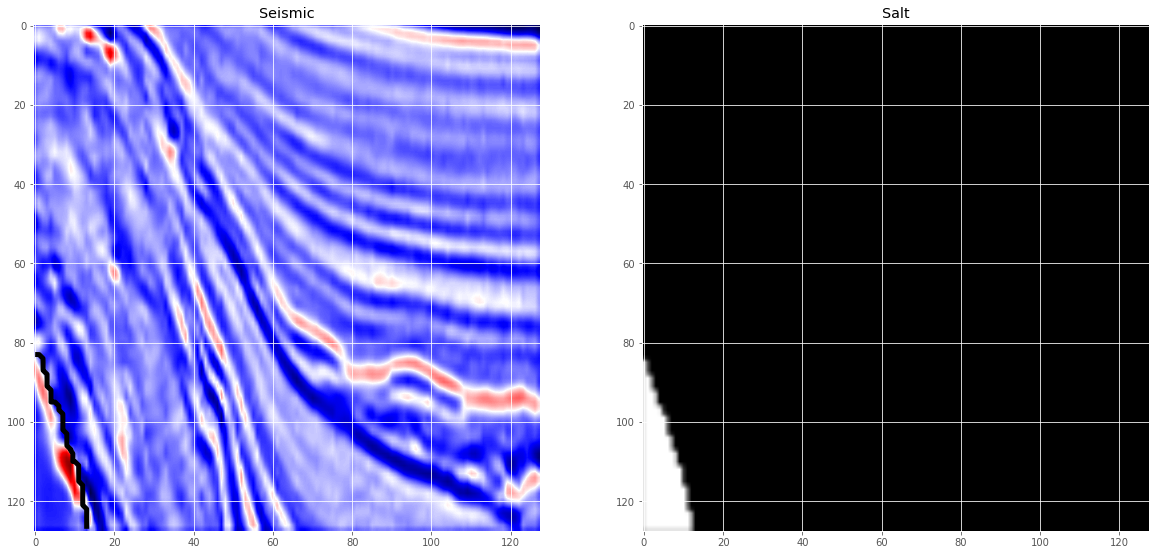

In [9]:
ix = random.randint(0, len(X_train))

# Indicating salt
has_mask = y_train[ix].max() > 0 

fig, ax = plt.subplots(1, 2, figsize = (20, 15))

ax[0].imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')

#if salt
if has_mask: 
    ax[0].contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax[1].set_title('Salt')

In [32]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
  
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
kernel_initializer = 'he_normal', padding = 'same')(input_tensor)

    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


In [33]:
def unet_model(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
   
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model


In [34]:
input_img = Input((im_height, im_width, 1), name='img')

In [39]:
model = unet_model(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(learning_rate = 0.00000001), loss="binary_crossentropy", metrics=["accuracy"])

In [40]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_valid, y_valid))


Epoch 1/50
113/113 [==============================] - 67s 69ms/step - loss: 19.5219 - accuracy: 0.5047 - val_loss: 15.9094 - val_accuracy: 0.6521
Epoch 2/50
113/113 [==============================] - 7s 66ms/step - loss: 19.2762 - accuracy: 0.5054 - val_loss: 26.0312 - val_accuracy: 0.6537
Epoch 3/50
113/113 [==============================] - 8s 67ms/step - loss: 19.4150 - accuracy: 0.5047 - val_loss: 27.8265 - val_accuracy: 0.6215
Epoch 4/50
113/113 [==============================] - 8s 67ms/step - loss: 19.4758 - accuracy: 0.5047 - val_loss: 26.9858 - val_accuracy: 0.5842
Epoch 5/50
113/113 [==============================] - 8s 67ms/step - loss: 19.4969 - accuracy: 0.5046 - val_loss: 25.3089 - val_accuracy: 0.5543
Epoch 6/50
113/113 [==============================] - 7s 66ms/step - loss: 19.3476 - accuracy: 0.5048 - val_loss: 24.1445 - val_accuracy: 0.5391
Epoch 7/50
113/113 [==============================] - 7s 66ms/step - loss: 19.3967 - accuracy: 0.5051 - val_loss: 23.5349 - val_a

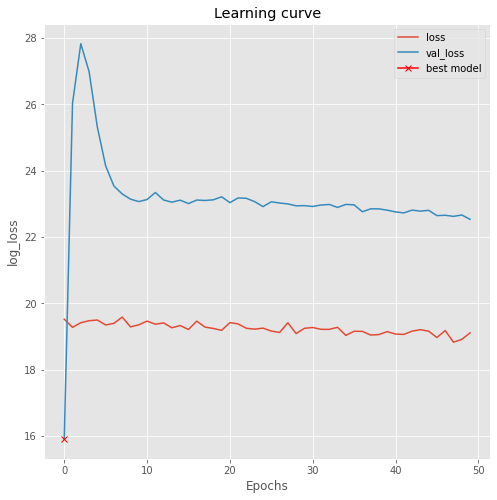

In [41]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [42]:
model.evaluate(X_valid, y_valid, verbose=1)

13/13 [==============================] - 0s 23ms/step - loss: 22.5327 - accuracy: 0.5276


[22.53268051147461, 0.5275886654853821]

In [43]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

13/13 [==============================] - 0s 16ms/step


In [44]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');


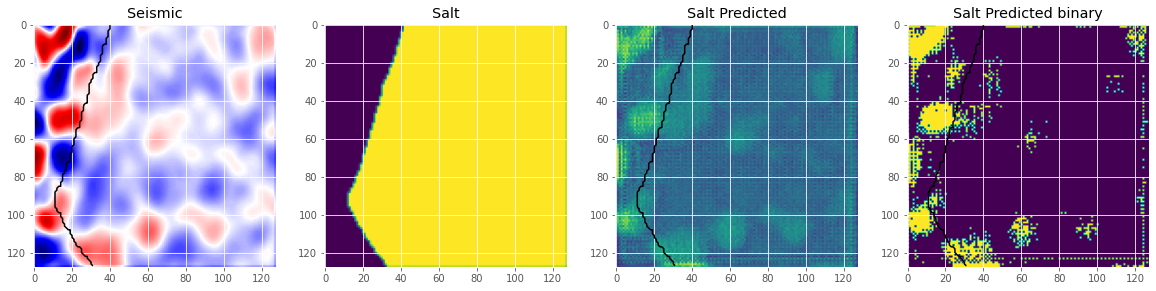

In [45]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)


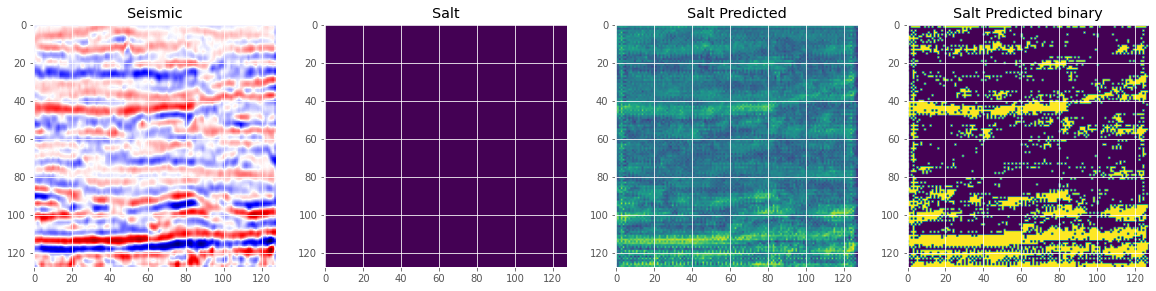

In [46]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

In [47]:
model.save("/content/drive/MyDrive/Python/TGS/Salt_Detection_update.h5")